In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# We are going to simulate people going to a certain stop of a certain line in one day
# We will use the data from the 2019-09-07
line = 71
#line = 29
line_schedule = pd.read_csv('schedules_filtered.csv')
line_schedule = line_schedule[line_schedule.line == line]
line_schedule = line_schedule[line_schedule.date == 20210908]
print(line_schedule.stop_id.unique())

[1597 1734 2296 2397 2596 2928 3502 3503 3506 3508 3510 3514 3515 3517
 3518 3520 5407 5611 6444 1598 2301 2351 2595 2948 2963 2964 2967 3521
 3525 3556 3557 3558 3559 3562 3567 3570 3572 5612 6447]


In [3]:
# We pick stop TRONE = 2948 in direction DE BROUCKÈRE
# Or stop DAILLY = 1566 in direction DE BROUCKÈRE
stop = 2948
#stop = 1566
stop_schedule = line_schedule[line_schedule.stop_id == stop]
stop_schedule = stop_schedule[stop_schedule.trip_headsign == 'DE BROUCKERE']
stop_schedule = stop_schedule.departure_time.reset_index(drop=True)
# Separate schedule in two columns: hour and minute (integers)
stop_schedule = stop_schedule.str.split(':', expand=True)
# Remove the last column
stop_schedule = stop_schedule.drop(stop_schedule.columns[2], axis=1)
# Rename the columns
stop_schedule.columns = ['hour', 'minute']
# Convert to integers
stop_schedule.hour = stop_schedule.hour.astype(int)
stop_schedule.minute = stop_schedule.minute.astype(int)
# Convert to minutes
stop_schedule = stop_schedule.hour * 60 + stop_schedule.minute
print(stop_schedule)

0       314
1       333
2       348
3       358
4       366
       ... 
173    1407
174    1419
175    1431
176    1443
177    1455
Length: 178, dtype: int64


In [4]:
# Now we read the real data 
stop_real = pd.read_csv('71_2948_estimated.csv')
#stop_real = pd.read_csv('29_1566_estimated.csv')
# We add two new columns, one with the date and another with the time
stop_real['date'] = stop_real['departure_time'].apply(lambda x: x.split(' ')[0])
stop_real['time'] = stop_real['departure_time'].apply(lambda x: x.split(' ')[1])
# We only keep the data from the 2019-09-07
stop_real = stop_real[stop_real.date == '2021-09-08'].time.reset_index(drop=True)
# We need to add two hours to the real data because the data is in UTC
stop_real = stop_real.apply(lambda x: str(int(x.split(':')[0]) + 2) + ':' + x.split(':')[1])

# We need to convert the real data to the same format as the schedule
stop_real = stop_real.str.split(':', expand=True)
stop_real.columns = ['hour', 'minute']
stop_real.hour = stop_real.hour.astype(int)
stop_real.minute = stop_real.minute.astype(int)
stop_real = stop_real.hour * 60 + stop_real.minute

print(stop_real)

0       331
1       348
2       358
3       368
4       378
       ... 
224    1409
225    1426
226    1433
227    1441
228    1455
Length: 229, dtype: int64


[ 879  798  917 ... 1051  829 1013]


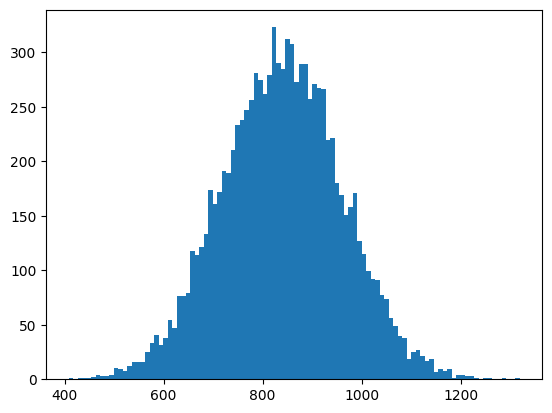

In [161]:
# We now have the real data and the scheduled data
# We can now simulate the people going to the stop
# We will use a Normal distribution to simulate the people
# The mean will be 14:00 
# The standard deviation will be 2 hours to cover most of the day
# We will simulate 1000 people
arrival_time = np.random.normal(14*60, 120, 10000)
arrival_time = arrival_time.astype(int)
print(arrival_time)
plt.hist(arrival_time, bins=100)
plt.show()

In [6]:
def simulate_normal(stop_schedule, stop_real, mean=14*60, std=2*60, N=1000):
    arrival_time = np.random.normal(mean, std, N)
    arrival_time = arrival_time.astype(int)

    # We create the datafram with columns:
    # - arrival_time: when the person arrives to the stop
    # - sw: how many minutes the person is supposed to wait, according to schedule
    # - rw: how many minutes the person actually waits, based on real data
    simulation_df = pd.DataFrame(columns=['arrival_time_hour', 'arrival_time_minute', 'sw', 'rw', 'difference'])
    # For each person we calculate the scheduled waiting time and the real waiting time
    for i in range(len(arrival_time)):
        sw = rw = 9999
        # We calculate the scheduled waiting time
        # We find the closest time in the schedule
        # We calculate the difference between the arrival time and the closest time
        # We add the difference to the scheduled waiting time
        our_time = arrival_time[i]
        closest_time = stop_schedule[(stop_schedule >= our_time) & (stop_schedule.shift() <= our_time)]
        if len(closest_time) > 0:
            closest_time = closest_time.sort_values(ascending=True).iloc[0]
            sw = closest_time - our_time
        # We calculate the real waiting time
        # We find the closest time in the real data
        # We calculate the difference between the arrival time and the closest time
        # We add the difference to the real waiting time
        closest_time = stop_real[(stop_real >= our_time) & (stop_real.shift() <= our_time)]
        if len(closest_time) > 0:
            closest_time = closest_time.sort_values(ascending=True).iloc[0]
            rw = closest_time - our_time
        # We add the data to the dataframe

        simulation_df = simulation_df.append({'arrival_time_hour': our_time//60, 'arrival_time_minute': our_time%60, 'sw': sw, 'rw': rw, 'difference': rw-sw}, ignore_index=True)
        #simulation_df['arrival_time'] = pd.to_datetime(simulation_df['arrival_time'])
    simulation_df = simulation_df[simulation_df.sw != 9999]
    simulation_df = simulation_df[simulation_df.rw != 9999]
    return simulation_df


def simulate_uniform(stop_schedule, stop_real, beginning=12*60, end=16*60, N=1000):
    arrival_time = np.random.uniform(beginning, end, N)
    arrival_time = arrival_time.astype(int)

    # We create the datafram with columns:
    # - arrival_time: when the person arrives to the stop
    # - sw: how many minutes the person is supposed to wait, according to schedule
    # - rw: how many minutes the person actually waits, based on real data
    simulation_df = pd.DataFrame(columns=['arrival_time_hour', 'arrival_time_minute', 'sw', 'rw', 'difference'])
    # For each person we calculate the scheduled waiting time and the real waiting time
    for i in range(len(arrival_time)):
        sw = rw = 9999
        # We calculate the scheduled waiting time
        # We find the closest time in the schedule
        # We calculate the difference between the arrival time and the closest time
        # We add the difference to the scheduled waiting time
        our_time = arrival_time[i]
        closest_time = stop_schedule[(stop_schedule >= our_time) & (stop_schedule.shift() <= our_time)]
        if len(closest_time) > 0:
            closest_time = closest_time.sort_values(ascending=True).iloc[0]
            sw = closest_time - our_time
        # We calculate the real waiting time
        # We find the closest time in the real data
        # We calculate the difference between the arrival time and the closest time
        # We add the difference to the real waiting time
        closest_time = stop_real[(stop_real >= our_time) & (stop_real.shift() <= our_time)]
        if len(closest_time) > 0:
            closest_time = closest_time.sort_values(ascending=True).iloc[0]
            rw = closest_time - our_time
        # We add the data to the dataframe

        simulation_df = simulation_df.append({'arrival_time_hour': our_time//60, 'arrival_time_minute': our_time%60, 'sw': sw, 'rw': rw, 'difference': rw-sw}, ignore_index=True)
        #simulation_df['arrival_time'] = pd.to_datetime(simulation_df['arrival_time'])
        # Delete where sw or rw is 9999
    simulation_df = simulation_df[simulation_df.sw != 9999]
    simulation_df = simulation_df[simulation_df.rw != 9999]
    return simulation_df

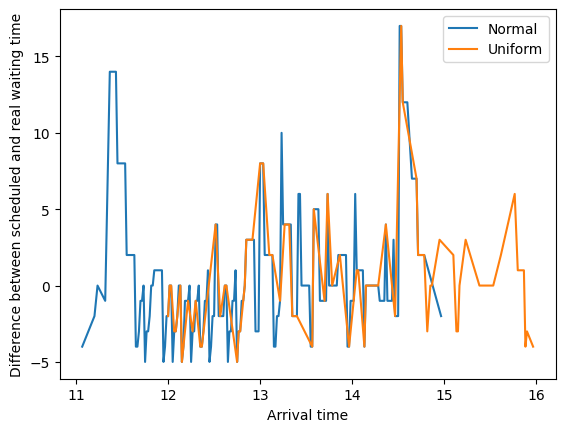

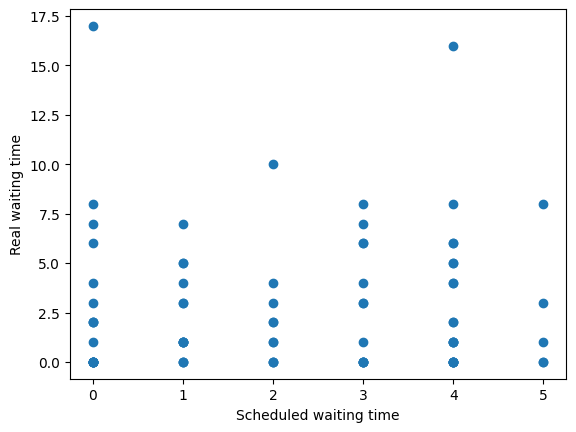

46


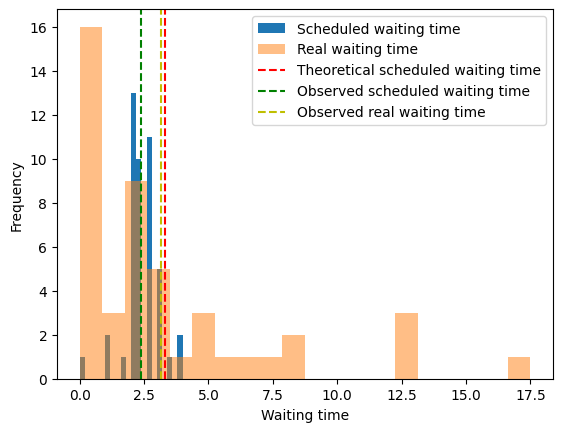

In [9]:
sim1 = simulate_normal(stop_schedule, stop_real, mean=13*60, std=0.5*60, N=10000)
sim2 = simulate_uniform(stop_schedule, stop_real, beginning=12*60, end=16*60, N=100)

# Let's aggregate the data, so we can plot it
# we will group by hour and each 15 minutes
sim1 = sim1.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()
sim2 = sim2.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()

# Plot difference against arrival_time_hour and arrival_time_minute
plt.plot(sim1.index.get_level_values(0) + sim1.index.get_level_values(1)/60, sim1['difference'], label='Normal')
plt.plot(sim2.index.get_level_values(0) + sim2.index.get_level_values(1)/60, sim2['difference'], label='Uniform')
plt.legend()
plt.xlabel('Arrival time')
plt.ylabel('Difference between scheduled and real waiting time')
plt.show()

# Plot sw against rw only for uniform distribution
plt.plot(sim2['sw'], sim2['rw'], 'o')
plt.xlabel('Scheduled waiting time')
plt.ylabel('Real waiting time')
plt.show()

# Let's plot the histogram of the sw 
sim1_g = sim1.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()
sim1_g = sim1_g.groupby([sim1_g.index.get_level_values(0)*60 + sim1_g.index.get_level_values(1)//5*5]).mean()
print(len(sim1_g))

swt = 200/60 # the theoretical waiting time
# We compute the observed waiting time as the average of sw and rw
swt_obs = sim1['sw'].mean()
awt_obs = sim1['rw'].mean()
# We also plot a line at the theoretical waiting time and the observed waiting time
plt.hist(sim1_g['sw'], bins=20, label='Scheduled waiting time')
plt.hist(sim1_g['rw'], bins=20, label='Real waiting time', alpha=0.5)
plt.axvline(x=swt, color='r', label='Theoretical scheduled waiting time', linestyle='--')
plt.axvline(x=swt_obs, color='g', label='Observed scheduled waiting time', linestyle='--')
plt.axvline(x=awt_obs, color='y', label='Observed real waiting time', linestyle='--')
plt.xlabel('Waiting time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

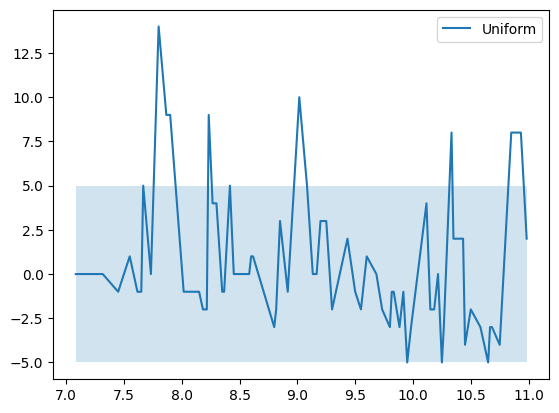

In [124]:
sim1 = simulate_normal(stop_schedule, stop_real, mean=9*60, std=0.5*60, N=100)
sim2 = simulate_uniform(stop_schedule, stop_real, beginning=7*60, end=11*60, N=100)

# Let's aggregate the data, so we can plot it
# we will group by hour and each 15 minutes
sim1 = sim1.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()
sim2 = sim2.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()

# Plot difference against arrival_time_hour and arrival_time_minute
plt.plot(sim2.index.get_level_values(0) + sim2.index.get_level_values(1)/60, sim2['difference'], label='Uniform')
plt.legend()
# Draw a band between y=-5 and y=5
plt.fill_between(sim2.index.get_level_values(0) + sim2.index.get_level_values(1)/60, -5, 5, alpha=0.2)


In [168]:
# Let's simulate a regularity interval: from 5:50 to 23:30
# Only for the uniform distribution
sim3 = simulate_uniform(stop_schedule, stop_real, beginning=5*60+50, end=23*60+30, N=20000)


212


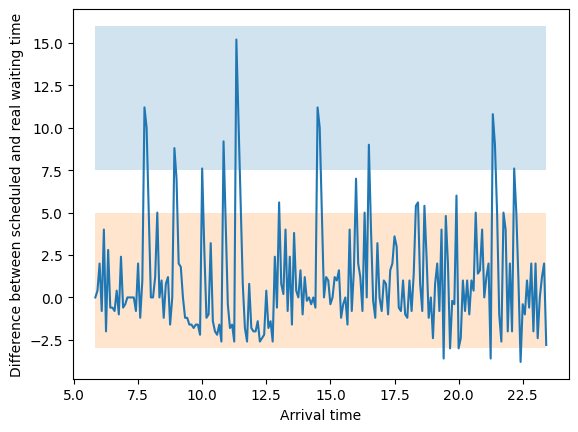

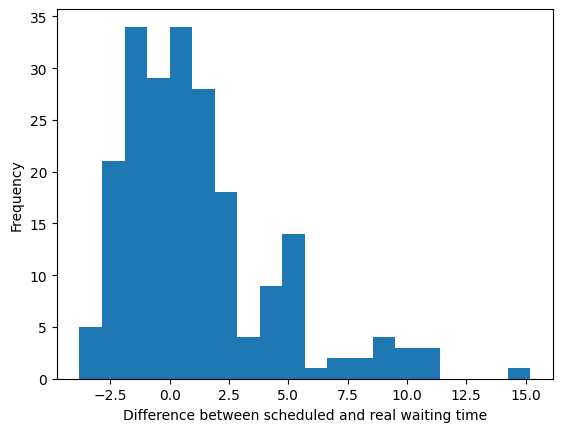

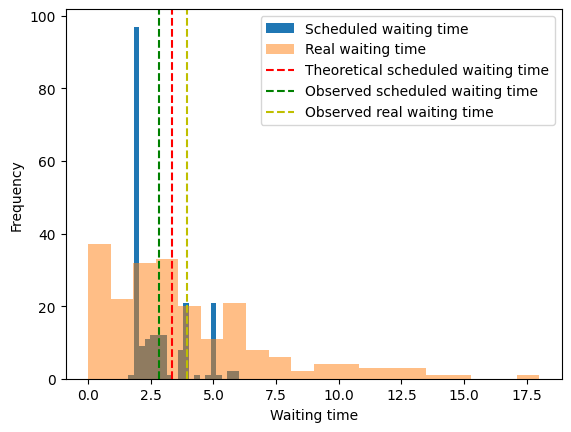

In [172]:
# Let's aggregate the data, so we can plot it
# we will group by each 15 minute interval of time
sim3_g = sim3.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()
sim3_g = sim3_g.groupby([sim3_g.index.get_level_values(0)*60 + sim3_g.index.get_level_values(1)//5*5]).mean()
print(len(sim3_g))

# Let's plot it
plt.plot(sim3_g.index/60, sim3_g['difference'])
plt.xlabel('Arrival time')
plt.ylabel('Difference between scheduled and real waiting time')
plt.fill_between(sim3_g.index/60, 7.5, 16, alpha=0.2)
plt.fill_between(sim3_g.index/60, -3, 5, alpha=0.2)
plt.show()

# We can also plot the histogram of the difference
plt.hist(sim3_g['difference'], bins=20)
plt.xlabel('Difference between scheduled and real waiting time')
plt.ylabel('Frequency')
plt.show()

# Let's plot the histogram of the sw 
swt = 200/60 # the theoretical waiting time
# We compute the observed waiting time as the average of sw and rw
swt_obs = sim3['sw'].mean()
awt_obs = sim3['rw'].mean()
# We also plot a line at the theoretical waiting time and the observed waiting time
plt.hist(sim3_g['sw'], bins=20, label='Scheduled waiting time')
plt.hist(sim3_g['rw'], bins=20, label='Real waiting time', alpha=0.5)
plt.axvline(x=swt, color='r', label='Theoretical scheduled waiting time', linestyle='--')
plt.axvline(x=swt_obs, color='g', label='Observed scheduled waiting time', linestyle='--')
plt.axvline(x=awt_obs, color='y', label='Observed real waiting time', linestyle='--')
plt.xlabel('Waiting time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [162]:
# Let's simulate a punctuality interval: from 20:50 to 24:30
# Only for the uniform distribution
sim3 = simulate_uniform(stop_schedule, stop_real, beginning=5*60+50, end=23*60+30, N=20000)

212


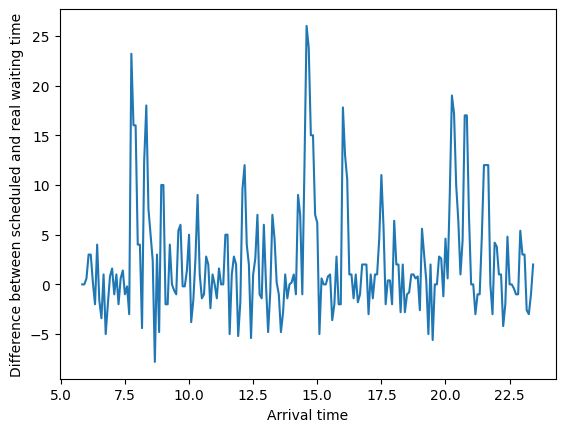

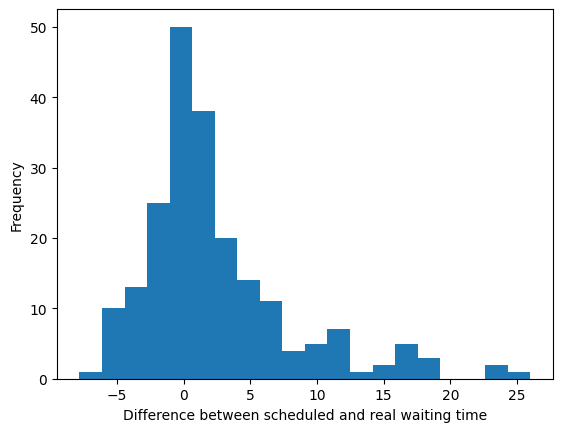

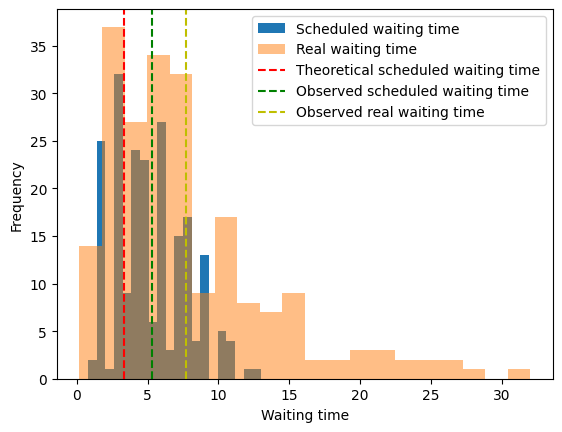

In [164]:
# Let's aggregate the data, so we can plot it
# we will group by each 15 minute interval of time
sim3_g = sim3.groupby(['arrival_time_hour', 'arrival_time_minute']).mean()
sim3_g = sim3_g.groupby([sim3_g.index.get_level_values(0)*60 + sim3_g.index.get_level_values(1)//5*5]).mean()
print(len(sim3_g))

# Let's plot it
plt.plot(sim3_g.index/60, sim3_g['difference'])
plt.xlabel('Arrival time')
plt.ylabel('Difference between scheduled and real waiting time')
plt.show()

# We can also plot the histogram of the difference
plt.hist(sim3_g['difference'], bins=20)
plt.xlabel('Difference between scheduled and real waiting time')
plt.ylabel('Frequency')
plt.show()

# Let's plot the histogram of the sw 
swt = 200/60 # the theoretical waiting time
# We compute the observed waiting time as the average of sw and rw
swt_obs = sim3['sw'].mean()
awt_obs = sim3['rw'].mean()
# We also plot a line at the theoretical waiting time and the observed waiting time
plt.hist(sim3_g['sw'], bins=20, label='Scheduled waiting time')
plt.hist(sim3_g['rw'], bins=20, label='Real waiting time', alpha=0.5)
plt.axvline(x=swt, color='r', label='Theoretical scheduled waiting time', linestyle='--')
plt.axvline(x=swt_obs, color='g', label='Observed scheduled waiting time', linestyle='--')
plt.axvline(x=awt_obs, color='y', label='Observed real waiting time', linestyle='--')
plt.xlabel('Waiting time')
plt.ylabel('Frequency')
plt.legend()
plt.show()